In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
protein_name = 'Hdock_Wuhan+V16ext'
fpath = f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/HDX_pred_{protein_name}_finetune.csv'
df = pd.read_csv(fpath)
print(df.shape)
print(df.columns)
print(df.head())
#print(df['Batch'].unique())

(56889, 5)
Index(['Batch', 'Y_True', 'Y_Pred', 'Chain', 'Range'], dtype='object')
                          Batch    Y_True    Y_Pred Chain      Range
0  Hdock_Wuhan+V16ext_1_revised  0.314043  0.172460     A  A_576-584
1  Hdock_Wuhan+V16ext_1_revised  0.121702  0.329569     B  B_179-191
2  Hdock_Wuhan+V16ext_1_revised  0.335662  0.333307     A   A_93-103
3  Hdock_Wuhan+V16ext_1_revised  0.142063  0.243171     C    C_32-42
4  Hdock_Wuhan+V16ext_1_revised  0.523263  0.171518     B  B_576-583


(3546, 12)
230
(3, 230)
230
230


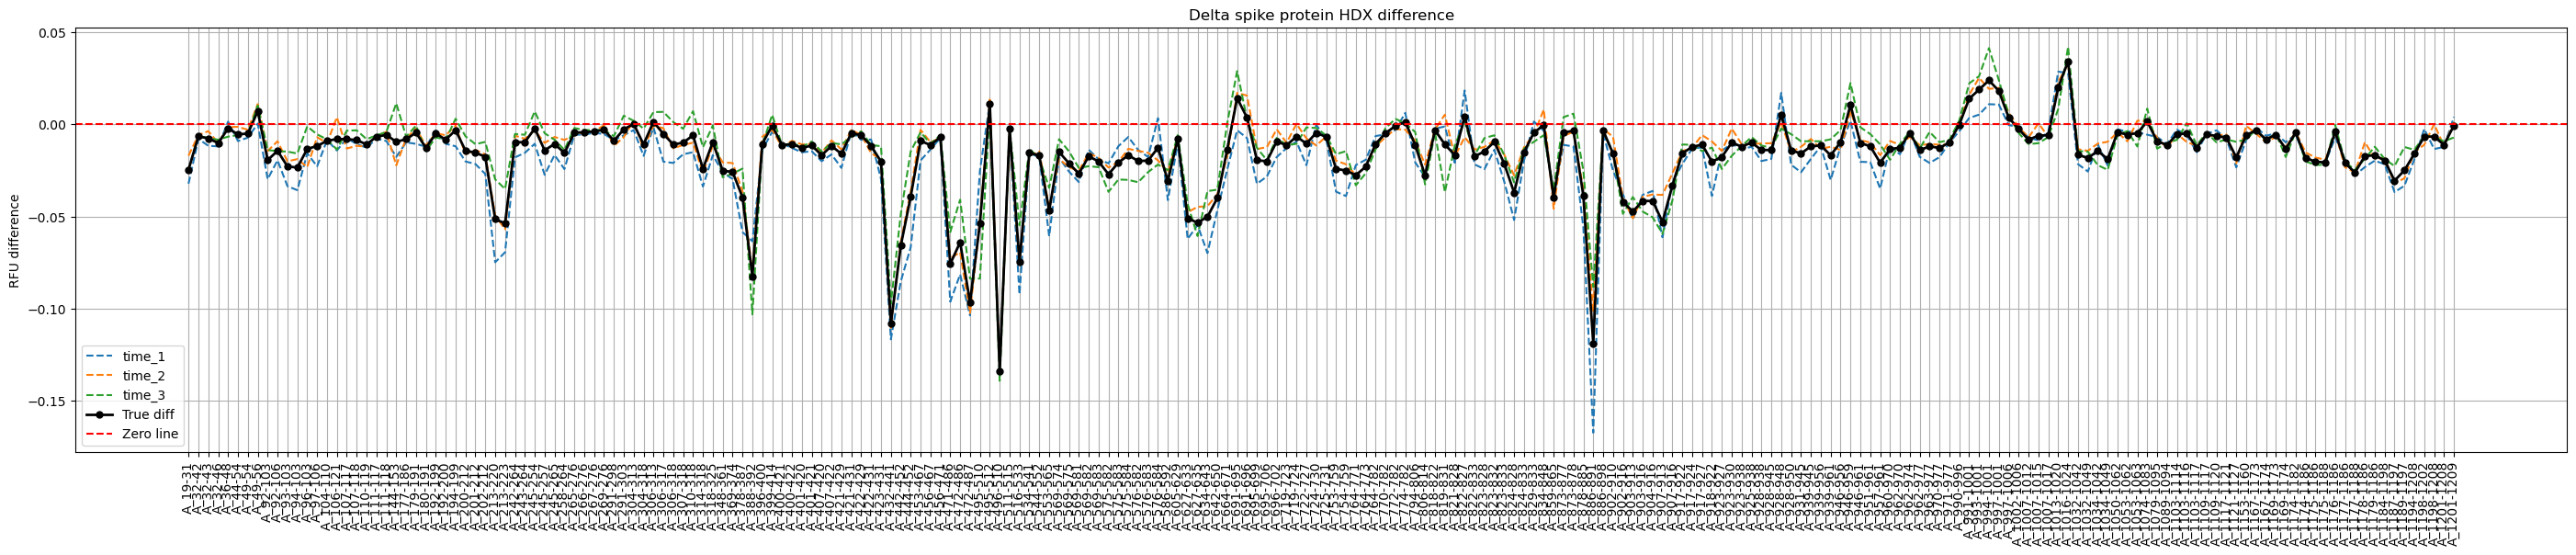

In [1]:
# get time-weighted uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_true_diff(HDX_fpath, apo_states, complex_states):
    def get_weighted_uptake(HDX_df, protein, state, chain):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])
        
        exposures = temp_HDX_df['log_t'].unique()
        unweighted_RFU = []
        for time in exposures:
            unweighted_RFU.append(temp_HDX_df[temp_HDX_df['log_t']==time]['%d'].to_numpy())
        unweighted_RFU = np.row_stack(unweighted_RFU)

        weighted_uptake = np.mean(unweighted_RFU, axis=0) / 100 # FIXME: percentage 

        temp_HDX_df = temp_HDX_df.drop_duplicates(subset=['sequence'], keep = 'last')
        start, end = temp_HDX_df['start'].to_numpy(), temp_HDX_df['end'].to_numpy()
        x_label = [f'{chain}_{start[i]}-{end[i]}' for i in range(len(start))]
        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    print(HDX_df.shape)
    true_apo = {}
    apo_uptake, x_label = [], []
    apo_mtx = []

    for protein, state, letter in apo_states:
        uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, letter)
        apo_uptake.append(uptake)
        apo_mtx.append(U_apo_mtx)
        x_label += label
    apo_uptake = np.concatenate(apo_uptake)
    apo_mtx = np.concatenate(apo_mtx, axis =1)

    for i in range(len(x_label)):
        true_apo[x_label[i]] = apo_uptake[i]
    print(len(true_apo.keys()))

    true_complex = {}
    complex_uptake, x_label = [], []
    complex_mtx = []

    for protein, state, letter in complex_states:
        uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, letter)
        complex_uptake.append(uptake)
        complex_mtx.append(U_complex_mtx)
        x_label += label
    complex_uptake = np.concatenate(complex_uptake)
    complex_mtx = np.concatenate(complex_mtx, axis =1)
    print(complex_mtx.shape)

    for i in range(len(x_label)):
        true_complex[x_label[i]] = complex_uptake[i]
    print(len(true_complex.keys()))

    true_diff = {}
    diff_mtx = complex_mtx - apo_mtx
    for key in true_apo.keys():
        true_diff[key] = true_complex[key] - true_apo[key]
    print(len(true_diff.keys()))
    return true_diff, diff_mtx

# Delta true diff 
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.xlsx'
apo_states = [('WUHAN_2nd', 'apo', 'A')] #(protein, state, chain)
complex_states = [('WUHAN_2nd', 'VH16_VL104', 'A')]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)

plt.figure(figsize=(35, 6))
plt.xticks(np.arange(0, len(true_diff.keys()), 1), list(true_diff.keys()), rotation=90)
for i in range(diff_RFU_mtx.shape[0]):
    plt.plot(diff_RFU_mtx[i, :]/100, label=f'time_{i+1}', linestyle = '--', alpha= 1)
plt.plot(list(true_diff.keys()) ,list(true_diff.values()), label='True diff', color = 'k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.title('Delta spike protein HDX difference')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.grid(True)
plt.legend()
plt.show()

71
71
71
(32, 5)
(32, 5)
32
32
MAE: 0.024948910077201125


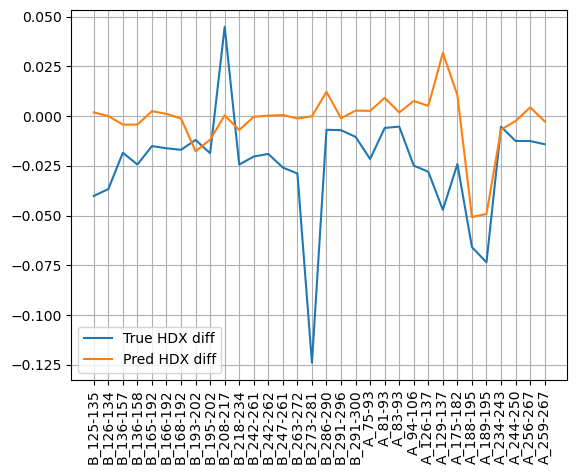

In [91]:
# show HDX difference
from sklearn.metrics import mean_absolute_error

true_diff = get_true_diff()
complex_true_df = df[df['Batch'] == 'model_25_revised']
print(complex_true_df.shape)
#true_dict = {}
#true_diff = {}
pred_dict = {}
pred_diff = {}
for i, row in complex_true_df.iterrows():
    #true_dict[row['Range']] = row['Y_True']
    pred_dict[row['Range']] = row['Y_Pred']

complex_baseline = df[df['Batch'] == 'finetune']
print(complex_baseline.shape)
for i, row in complex_baseline.iterrows():
    range_label = row['Range']
    #if range_label in true_dict:
    #    true_diff[range_label] = true_dict[range_label] - row['Y_True']
    if range_label in pred_dict:
        pred_diff[range_label] = pred_dict[range_label] - row['Y_Pred']

trim_true_diff = {}
for key in true_diff.keys():
    if key in pred_diff.keys():
        trim_true_diff[key] = true_diff[key]
print(len(trim_true_diff.keys()))
print(len(pred_diff.keys()))
x_labels = list(trim_true_diff.keys())
x_index = np.arange(len(x_labels))
y_true = np.array(list(trim_true_diff.values()))
y_pred = np.array([pred_diff[key] for key in x_labels])

MAE = mean_absolute_error(y_true, y_pred)
print('MAE:', MAE)

plt.xticks(x_index, x_labels, rotation=90)
plt.plot(x_labels, y_true, label='True HDX diff')
plt.plot(x_labels, y_pred, label='Pred HDX diff')
#plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

Top 10 models:
model_80 , 0.9658710222103458 

model_84 , 1.0471749698193278 

model_50 , 1.052285464941181 

model_69 , 1.0578324915787922 

model_1 , 1.0671349458969475 

model_12 , 1.0687380573163203 

model_40 , 1.0728858461828232 

model_96 , 1.0936286887118551 

model_67 , 1.094401686420628 

model_41 , 1.100241177851791 



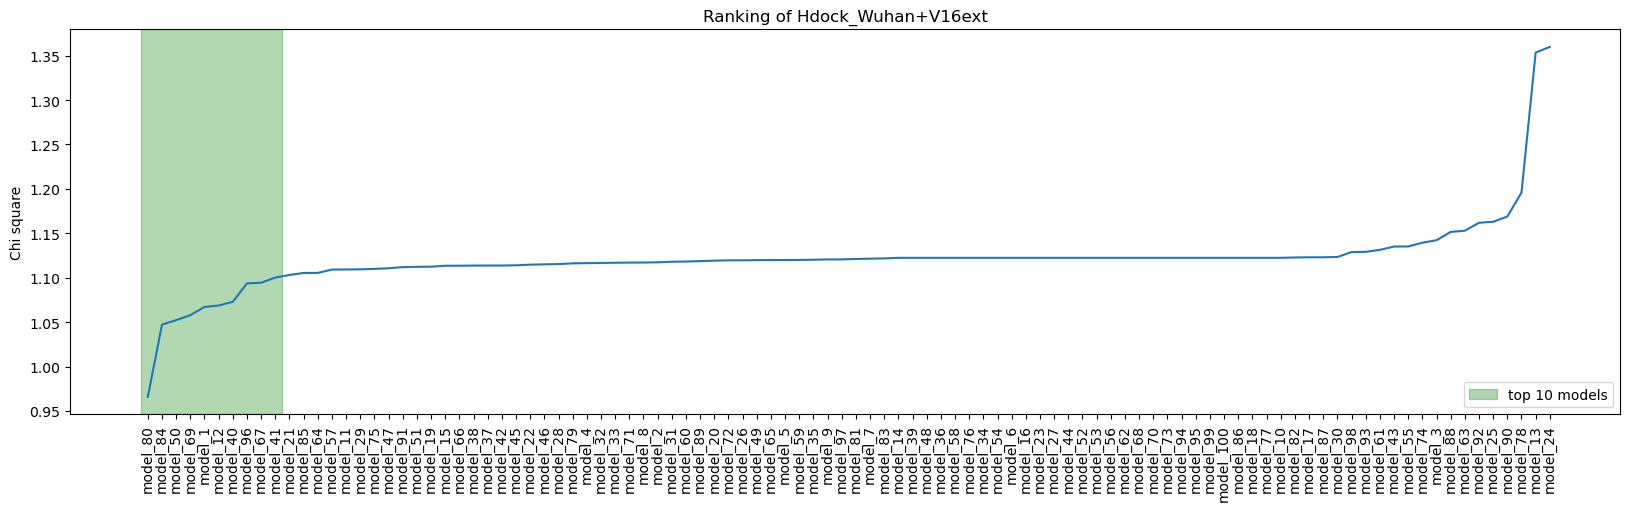

In [8]:
# batch MAE
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip predictions to avoid log(0)
    bce = -np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)) / y_true.shape[0]
    return bce
def mean_squared_error(y_true, y_pred, error_limit):
    return np.mean(((y_true - y_pred)/error_limit) ** 2)

def get_mae(df, batch_name, true_diff):
    complex_true_df = df[df['Batch'] == batch_name]
    pred_dict = {}
    pred_diff = {}
    for i, row in complex_true_df.iterrows():
        pred_dict[row['Range']] = row['Y_Pred']

    complex_baseline = df[df['Batch'] == 'finetune'] 
    for i, row in complex_baseline.iterrows(): # FIXME: only for chain A 
        range_label = row['Range']
        if range_label in pred_dict:
            pred_diff[range_label] = pred_dict[range_label] - row['Y_Pred']

    trim_true_diff = {}
    for key in true_diff.keys():
        if key in pred_diff.keys():
            trim_true_diff[key] = true_diff[key]
    x_labels = list(trim_true_diff.keys())
    x_index = np.arange(len(x_labels))
    y_true = np.array(list(trim_true_diff.values()))
    y_pred = np.array([pred_diff[key] for key in x_labels])

    #transformation
    #y_true = sigmoid(y_true)
    #y_pred = sigmoid(y_pred)
    #loss = binary_cross_entropy(y_true, y_pred)
    error_limit = 0.025
    loss = mean_squared_error(y_true, y_pred, error_limit)
    return loss

# you should get true_diff from previous cell
batches = [f'{protein_name}_{i}_revised' for i in range(1, 101)] # truncated rtt-bcd; 101-201: AF_rtt_bcd hdock models
model_name = [f'model_{i}' for i in range(1, 101)]
maes = []
for batch in batches:
    mae = get_mae(df, batch, true_diff)
    maes.append(mae)

sorted_batch = sorted(zip(batches, maes, model_name), key=lambda x: x[1])

print('Top 10 models:')
for rank in sorted_batch[:10]:
    print(rank[2], ',', rank[1], '\n')

plt.figure(figsize = (20, 5))
x_index = np.arange(len(batches))
plt.xticks(x_index, [i[2] for i in sorted_batch], rotation=90)
plt.axvspan(-0.5, 9.5, color='green', label = 'top 10 models', alpha=0.3)
plt.plot([i[1] for i in sorted_batch])
plt.ylabel('Chi square')
plt.title(f'Ranking of {protein_name}')
plt.legend()
plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_ranking.png')

G1: 90.13922550318362
G2: 110.39240575446829
G3: 88.02016600229774
G4: 102.00682561716341
G5: 98.73758372590572
G6: 103.66422439338939
(100, 6)


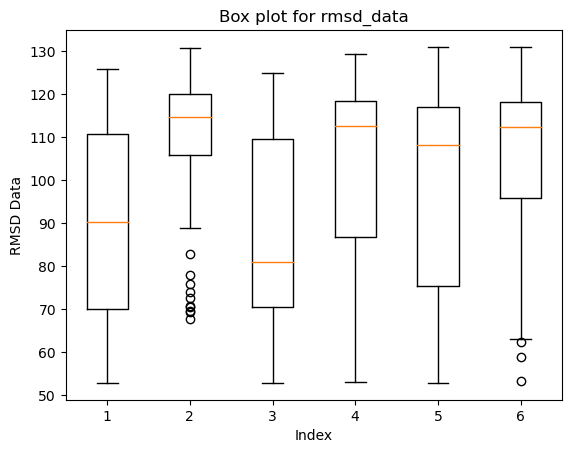

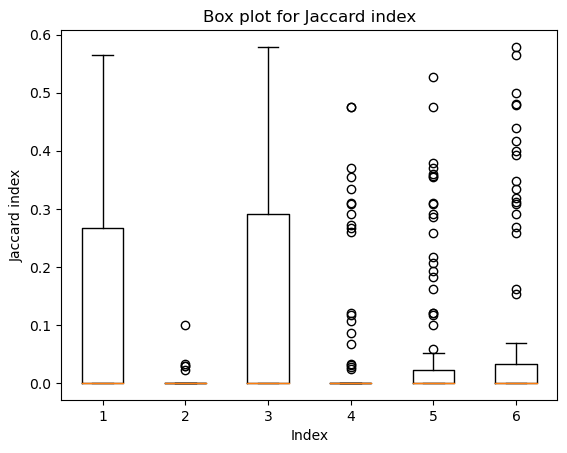

In [82]:
# calculate structure RMSD
from Bio.PDB import PDBParser
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
def get_RMSD(pdb_dir, model2, ref_model, ref_chains=['A']):
    parser = PDBParser()
    structure1 = parser.get_structure("Protein1", f"{pdb_dir}/{ref_model}.pdb")
    structure2 = parser.get_structure("Protein2", f"{pdb_dir}/{model2}.pdb")

    # Select the backbone atoms from each structure
    def get_backbone_atoms(structure):
        atoms = []
        for model in structure:
            for chain in model:
                if chain.id in ref_chains:
                    continue
                for residue in chain:
                    # Check if the residue has the backbone atoms (N, CA, C)
                    try:
                        atoms.append(residue['N'].get_coord())
                        atoms.append(residue['CA'].get_coord())
                        #atoms.append(residue['C'].get_coord())
                    except KeyError:
                        # Skip residues that don't have a complete set of backbone atoms
                        continue
        return atoms

    backbone_atoms1 = get_backbone_atoms(structure1)
    backbone_atoms2 = get_backbone_atoms(structure2)
    # calcualte the distance between backbone_atoms1 and backbone_atoms2
    rmsd = np.sqrt(np.sum((np.array(backbone_atoms1) - np.array(backbone_atoms2))**2)/len(backbone_atoms1))
    return rmsd

rmsd_data = []
jaccard_data = []
for j in range(1, 7):
    model = f'G{j}'
    pdb_dir = f'/home/lwang/models/HDX_LSTM/data/RTT_BCD/hdock/Hdock_AF_rtt+bcd_G{j}'
    ref_model = 'AF_rtt_bcd_complex'
    ref_chains = ['A']
    model_list = [f'Hdock_AF_rtt+bcd_G{j}_{i}_revised' for i in range(1, 101)]
    rmsd = []
    jaccard = []

    chains = read_PDB('', f'{pdb_dir}/{ref_model}.pdb')
    _, contact_list1 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)

    for model2 in model_list:
        chains = read_PDB('AF_rtt_bcd_complex', f'{pdb_dir}/{model2}.pdb')
        _, contact_list2 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)
        j_index = len(set.intersection(set(contact_list1[:,0]), set(contact_list2[:,0]))) / len(set.union(set(contact_list1[:,0]), set(contact_list2[:,0])))
        jaccard.append(j_index)

        rmsd.append(get_RMSD(pdb_dir, model2, ref_model, ref_chains))
    print(f'{model}:', np.mean(rmsd))
    rmsd_data.append(rmsd)
    jaccard_data.append(jaccard)
    

rmsd_data = np.array(rmsd_data).transpose()
print(rmsd_data.shape)
plt.figure()
plt.boxplot(rmsd_data)
plt.title('Box plot for rmsd_data')
plt.xlabel('Index')
plt.ylabel('RMSD Data')
plt.show()

jaccard_data = np.array(jaccard_data).transpose()
plt.figure()
plt.boxplot(jaccard_data)
plt.title('Box plot for Jaccard index')
plt.xlabel('Index')
plt.ylabel('Jaccard index')
plt.show()

(100, 6)
(100, 6)
(100, 6)
PearsonRResult(statistic=0.369570577961576, pvalue=0.00015424823371145042)
SignificanceResult(statistic=0.30851485148514846, pvalue=0.0017907178376343881)


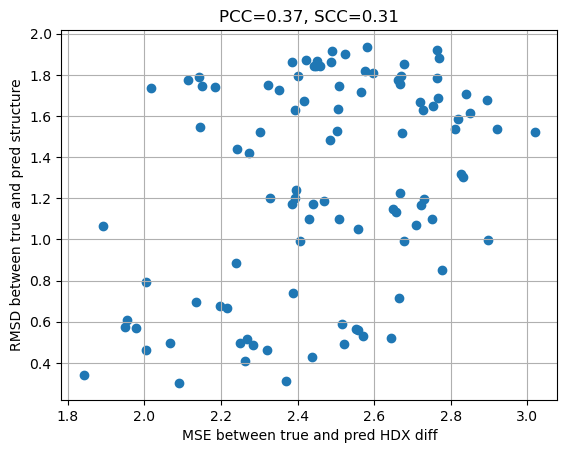

In [97]:
print(rmsd_data.shape)
print(jaccard_data.shape)

eps = 1e-6
temp_jaccard = 1-jaccard_data
#temp_jaccard = np.log(1-jaccard_data+eps)

rescaled_jaccard = (temp_jaccard - np.min(temp_jaccard)) / (np.max(temp_jaccard) - np.min(temp_jaccard))
rescaled_rmsd = (rmsd_data - np.min(rmsd_data)) / (np.max(rmsd_data) - np.min(rmsd_data))
combined_score = rescaled_jaccard + rescaled_rmsd
print(combined_score.shape)

from scipy.stats import pearsonr, spearmanr
# plot RMSD and mae index
pcc = pearsonr(maes, combined_score[:,0])
scc = spearmanr(maes, combined_score[:,0])
print(pcc)
print(scc)

plt.xlabel('MSE between true and pred HDX diff')
plt.ylabel('RMSD between true and pred structure')
plt.grid()
plt.title(f'PCC={pcc[0]:.2f}, SCC={scc[0]:.2f}')
plt.scatter(maes, combined_score[:,0])


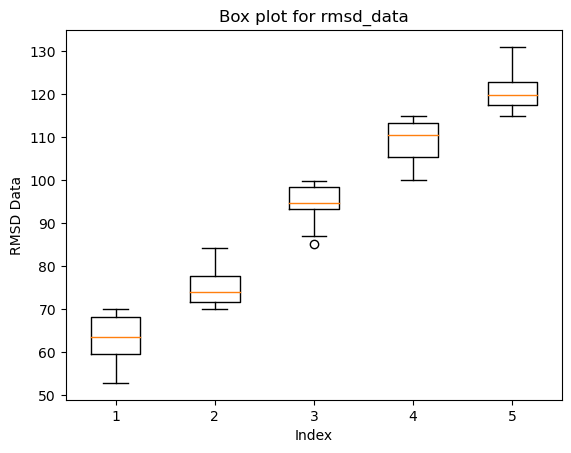

In [24]:

rmsd_bins = [0, 70, 85, 100, 115, 200]
rmsd_labels = [f'{rmsd_bins[i]}-{rmsd_bins[i+1]}' for i in range(len(rmsd_bins)-1)]
rmsd_group = np.digitize(rmsd_data, bins=rmsd_bins)

rmsd_digitize = []
for i in range(1, len(rmsd_bins)):
    rmsd_digitize.append(rmsd_data[rmsd_group == i])
rmsd_digitize = np.array(rmsd_digitize)
plt.figure()
plt.boxplot(rmsd_digitize)
plt.title('Box plot for rmsd_data')
plt.xlabel('Index')
plt.ylabel('RMSD Data')
plt.show()

In [9]:
## extract binding site

from collections import defaultdict
import os
import numpy as np
from scipy.spatial.distance import cdist
from Bio import PDB
from itertools import groupby

class Chain:
    def __init__(self):
        self.atoms = []
        self.sequence_type = None

    def add_atom(self, atom_index, residue_index, residue_type, atom_type, coordinates):
        atom_info = {
            'atom_index': atom_index,
            'residue_index': residue_index,
            'residue_type': residue_type,
            'atom_type': atom_type,
            'coordinates': coordinates
        }
        self.atoms.append(atom_info)

    def get_atoms(self):
        return self.atoms
    
    def get_residues(self):
        # group atoms by residue
        atoms = self.get_atoms()
        key = lambda x: x['residue_index']
        #atoms = sorted(atoms, key=key)
        residues = [list(group) for key, group in groupby(atoms, key)]
        return residues

def read_PDB(key, PDB_path):
    if not os.path.isfile(PDB_path):
        print("cannot find the file", key)
        return None
    chains = defaultdict(Chain)

    with open(PDB_path, 'r') as f:
        data = f.read().strip().split('\n') 
        for line in data:
            if line[:4] == 'ATOM':
                n_res = int(line[23:26].strip())
                n_atom = int(line[6:11].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                chain = line[21].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                if atom_type == 'CA':
                    chains[chain_id].add_atom(n_atom, n_res, res_type, atom_type, [x, y, z])
    return chains

def bindingsite_extract(chains, chain1 = 'A', chain2 = 'B', dist_cutoff=3.65): ###assume only two chains in the PDB file
    chainA = chains[chain1]
    chainB = chains[chain2]
    coords_a = [atom['coordinates'] for atom in chainA.get_atoms()]
    coords_b = [atom['coordinates'] for atom in chainB.get_atoms()]

    coords_array_a = np.array(coords_a)
    coords_array_b = np.array(coords_b)
    dist_matrix = cdist(coords_array_a, coords_array_b, 'euclidean')

    pairs = dist_criterion(dist_matrix, cutoff=dist_cutoff) # different criterion can be used here
    contact_list = []
    for pair in pairs:
        resA_id = pair[0]
        resB_id = pair[1]

        resA = chainA.get_atoms()[resA_id]['residue_index']
        resB = chainB.get_atoms()[resB_id]['residue_index']
        contact_list.append((resA, resB))
    contact_list = np.array(contact_list)
    if contact_list.shape[0] == 0:
        return None, None
    
    max_res_A = max([res['residue_index'] for res in chainA.get_atoms()])
    max_res_B = max([res['residue_index'] for res in chainB.get_atoms()])
    contact_resmap = np.zeros((max_res_A, max_res_B))
    contact_resmap[contact_list[:, 0]-1, contact_list[:, 1]-1] = 1

    return contact_resmap, contact_list

def dist_criterion(dist_matrix, cutoff):
    dist_matrix = np.array(dist_matrix)
    mask = dist_matrix < cutoff
    indices = np.where(mask)
    pairs = list(zip(indices[0], indices[1]))
    return pairs

In [14]:
id_list = [80, 84, 50, 69, 1, 12, 40, 96, 67, 41]
pdb_list = [f'{protein_name}_{i}_revised.pdb' for i in id_list]

rec_chain = ['A', 'C']
lig_chain = ['D', 'E']

map_dict = {}
for pdb in pdb_list:
    print(pdb)
    pdb_fpath = f'/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/hdock/{protein_name}/{pdb}'
    chains = read_PDB('model1', pdb_fpath)
    for rec in rec_chain:
        for lig in lig_chain:
            contact_, contact_list = bindingsite_extract(chains, chain1=rec, chain2=lig, dist_cutoff=10)
            if contact_list is None:
                continue
            if (rec, lig) not in map_dict.keys():
                map_dict[(rec, lig)] = []
            map_dict[(rec, lig)].extend(list(contact_list))
print(map_dict.keys())

D_contact = map_dict[('A', 'D')] + map_dict[('C', 'D')]
E_contact = map_dict[('A', 'E')] + map_dict[('C', 'E')]

D_res_map = np.zeros((999, 128))
E_res_map = np.zeros((999, 105))

for pos in D_contact:
    D_res_map[pos[0]-1, pos[1]-1] += 1
for pos in E_contact:
    E_res_map[pos[0]-1, pos[1]-1] += 1

Hdock_Wuhan+V16ext_80_revised.pdb
Hdock_Wuhan+V16ext_84_revised.pdb
Hdock_Wuhan+V16ext_50_revised.pdb
Hdock_Wuhan+V16ext_69_revised.pdb
Hdock_Wuhan+V16ext_1_revised.pdb
Hdock_Wuhan+V16ext_12_revised.pdb
Hdock_Wuhan+V16ext_40_revised.pdb
Hdock_Wuhan+V16ext_96_revised.pdb
Hdock_Wuhan+V16ext_67_revised.pdb
Hdock_Wuhan+V16ext_41_revised.pdb
dict_keys([('A', 'D'), ('A', 'E'), ('C', 'E'), ('C', 'D')])


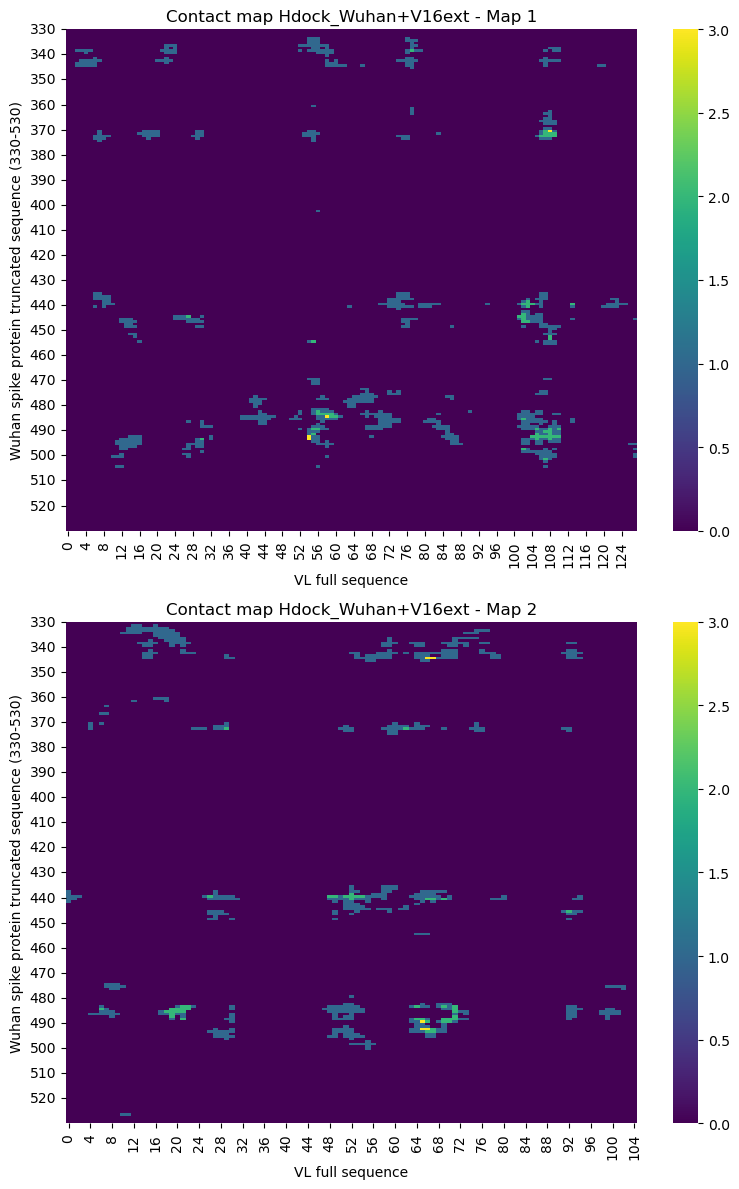

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
def plot_resmap(res_map1, res_map2):
    fig, axs = plt.subplots(2, 1, figsize=(8,12))  # create a figure with two subplots arranged vertically

    # plot the first heatmap
    sns.heatmap(res_map1, cmap='viridis', ax=axs[0])
    axs[0].set_xlabel('VL full sequence')
    axs[0].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[0].set_title(f'Contact map {protein_name} - Map 1')
    axs[0].set_yticks(np.arange(0, res_map1.shape[0], 10))
    axs[0].set_yticklabels(np.arange(330, 530, 10))

    # plot the second heatmap
    sns.heatmap(res_map2, cmap='viridis', ax=axs[1])
    axs[1].set_xlabel('VL full sequence')
    axs[1].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[1].set_title(f'Contact map {protein_name} - Map 2')
    axs[1].set_yticks(np.arange(0, res_map2.shape[0], 10))
    axs[1].set_yticklabels(np.arange(330, 530, 10))

    plt.tight_layout()  # adjust the layout so that the plots do not overlap
    plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_resmap.png')

plot_resmap(D_res_map[330:530, :], E_res_map[330:530, :])

In [4]:
from pepGraph_utlis import read_PDB, bindingsite_extract

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/RTT_BCD/hdock/Hdock_AF_rtt+bcd_G1/Hdock_AF_rtt+bcd_G1_20_revised.pdb'
chains = read_PDB('Hdock_AF_rtt+bcd_G1_1_revised', pdb_fpath)
contact_resmap, contact_list1 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)


pdb_fpath = '/home/lwang/models/HDX_LSTM/data/RTT_BCD/hdock/Hdock_AF_rtt+bcd_G1/AF_rtt_bcd_complex.pdb'
chains = read_PDB('AF_rtt_bcd_complex', pdb_fpath)
contact_resmap, contact_list2 = bindingsite_extract(chains, chain1='A', chain2='B', dist_cutoff=8.5)

#compute jaccard index
def jaccard_index(contact_list1, contact_list2):
    set1 = set([tuple(item) for item in contact_list1])
    set2 = set([tuple(item) for item in contact_list2])
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard = len(intersection) / len(union)
    return jaccard
print(contact_list1.shape)
print(contact_list2.shape)
print(contact_list1)
print(set(contact_list2[:, 0]))

j_index = len(set.intersection(set(contact_list1[:, 0]), set(contact_list2[:, 0])))/ len(set.union(set(contact_list1[:, 0]), set(contact_list2[:, 0])))
print(j_index)

#j_index= jaccard_index(np.unique(contact_list1[:, 0]), np.unique(contact_list2[:, 0]))
print(j_index)

(36, 2)
(60, 2)
[[ 70 124]
 [ 70 125]
 [ 70 126]
 [ 70 127]
 [ 70 251]
 [ 71 127]
 [ 71 249]
 [ 71 251]
 [ 73 127]
 [ 73 128]
 [ 73 129]
 [ 95 249]
 [100 248]
 [100 249]
 [173 128]
 [174 128]
 [174 129]
 [174 130]
 [175 130]
 [176 152]
 [178 154]
 [187 131]
 [188 130]
 [188 131]
 [188 132]
 [191 131]
 [191 132]
 [191 274]
 [191 275]
 [192 132]
 [192 275]
 [194 275]
 [195 132]
 [195 248]
 [195 274]
 [195 275]]
{192, 195, 70, 71, 72, 73, 74, 75, 170, 171, 172, 173, 174, 175, 94, 95}
0.391304347826087
0.391304347826087


In [1]:
from pyhdx import read_dynamx, HDXMeasurement
from pyhdx.process import filter_peptides, apply_control, correct_d_uptake
from pyhdx.plot import peptide_coverage
import proplot as pplt
from pathlib import Path
import pandas as pd
import numpy as np

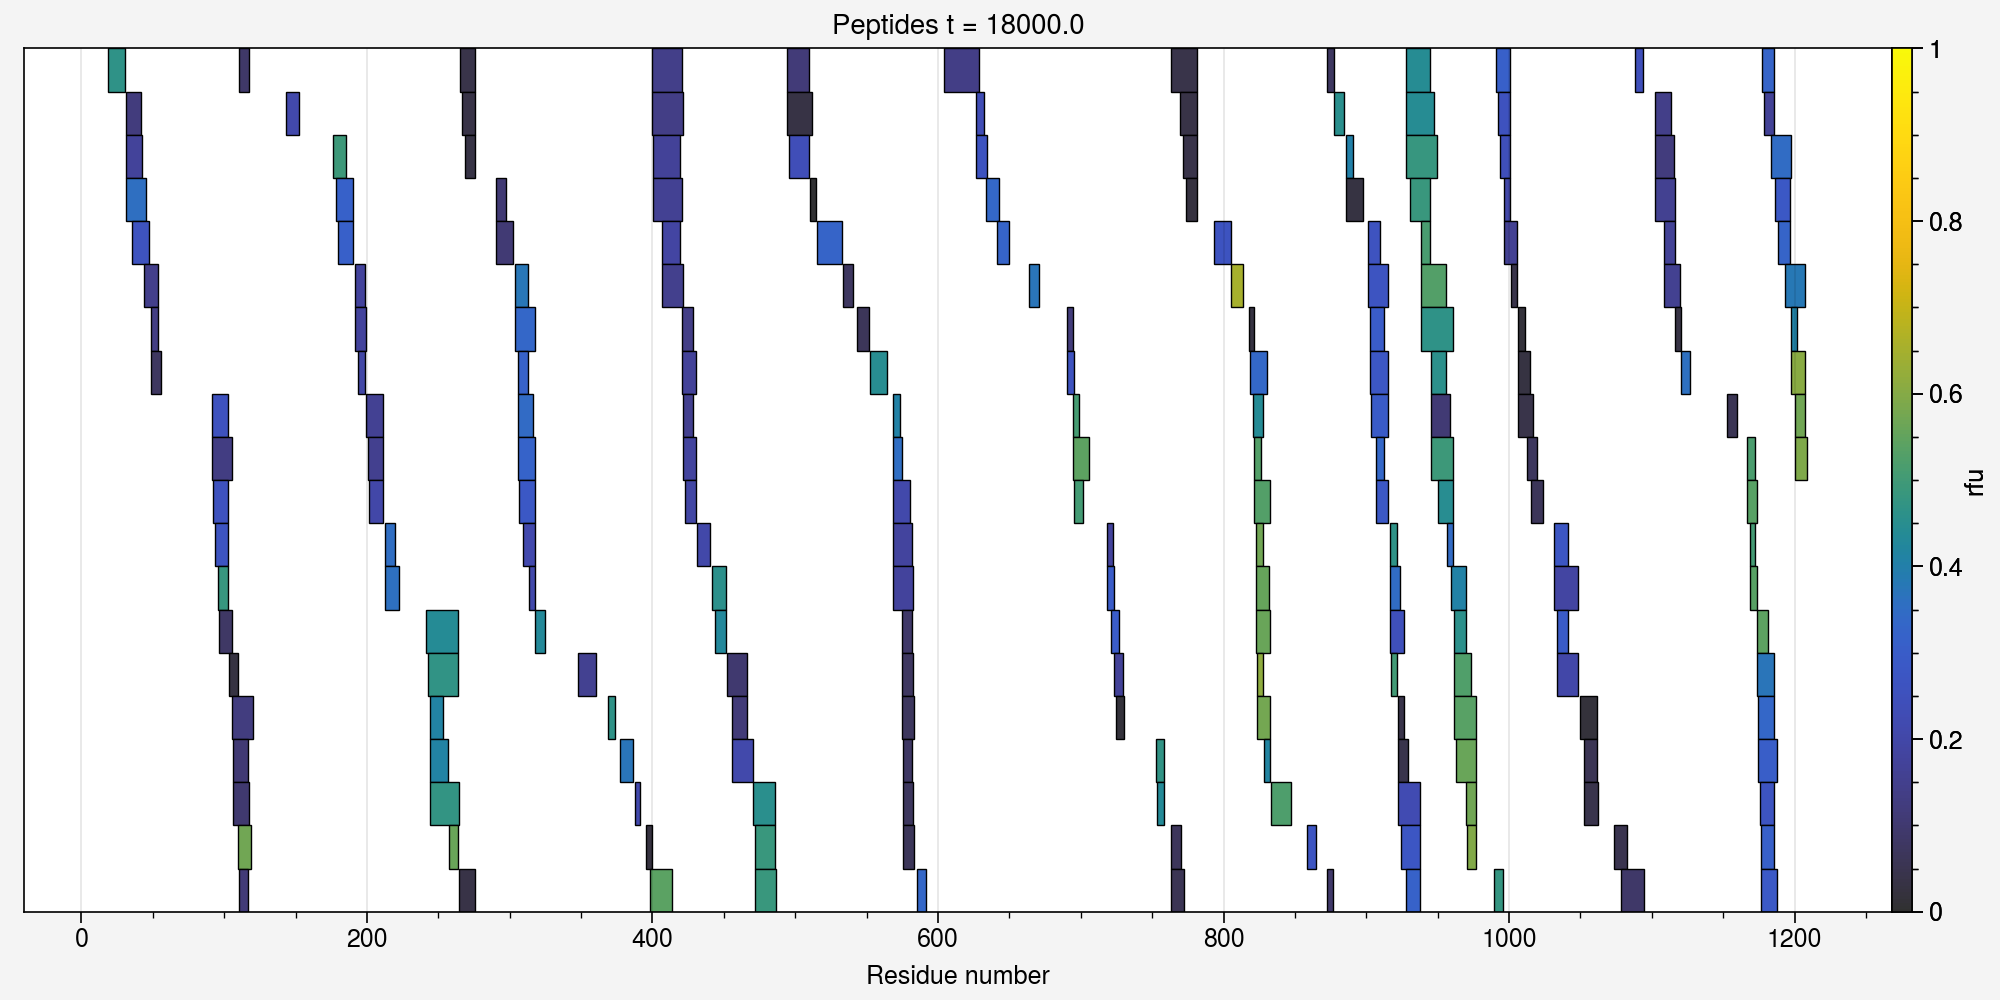

In [4]:
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
data = read_dynamx(fpath)
data['rfu'] = data['%d'] / 100

peptides = data[(data['protein'] == 'WUHAN_2nd') & (data['state'] == 'apo')]

peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
temperature, pH = 273.15 + 25, 7.5

hdxm = HDXMeasurement(
    peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
)

fig, ax = pplt.subplots(figsize=(10, 5))
i = 0
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
t = ax.set_title(f"Peptides t = {hdxm.timepoints[i]}")
l = ax.set_xlabel("Residue number")

In [5]:
import numpy as np
import pandas as pd
import proplot as pplt
from scipy.optimize import lsq_linear
from pathlib import Path
import yaml

from pyhdx.models import Coverage
from pyhdx.plot import peptide_coverage
from pyhdx.batch_processing import StateParser
from pyhdx.fitting import fit_d_uptake
from pyhdx.config import cfg

/home/lwang/models/mambaforge/envs/pyhdx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def compute_d_uptake(fpath, states, sequence):
    data = read_dynamx(fpath)
    data['rfu'] = data['%d'] / 100

    fit_result = []
    for state in states:
        peptides = data[(data['protein'] == state[0]) & (data['state'] == state[1])]
        peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)
        temperature, pH = 273.15 + 25, 7.5
        hdxm = HDXMeasurement(
            peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
        )
        hdx_t = hdxm[1]
        fit_result.append(fit_d_uptake(hdx_t, r1=1.0, repeats=20))
    
    fit_diff = fit_result[1].d_uptake.mean(axis=0) - fit_result[0].d_uptake.mean(axis=0)

    return hdx_t.r_number ,fit_diff

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
states = [('WUHAN_2nd', 'apo', 'A'), ('WUHAN_2nd', 'VH16_VL104', 'A')]
r_id, fit_diff = compute_d_uptake(fpath, states, sequence)


100%|██████████| 20/20 [04:00<00:00, 12.03s/it]


In [6]:
hdx_t = hdxm[1]
b = hdx_t.data["uptake_corrected"].values
X_inv = np.linalg.pinv(hdx_t.X)
d_inv = X_inv.dot(b)
# Remove parts which do not exchange (prolines, coverage gaps)
d_inv[~hdx_t["exchanges"]] = np.nan

res = lsq_linear(hdx_t.X, b, method="bvls", bounds=(0, 1))
d_lsq = res.x
d_lsq[~hdx_t["exchanges"]] = np.nan

fit_result_1 = fit_d_uptake(hdx_t, r1=1.0, repeats=20)

100%|██████████| 20/20 [04:03<00:00, 12.18s/it]


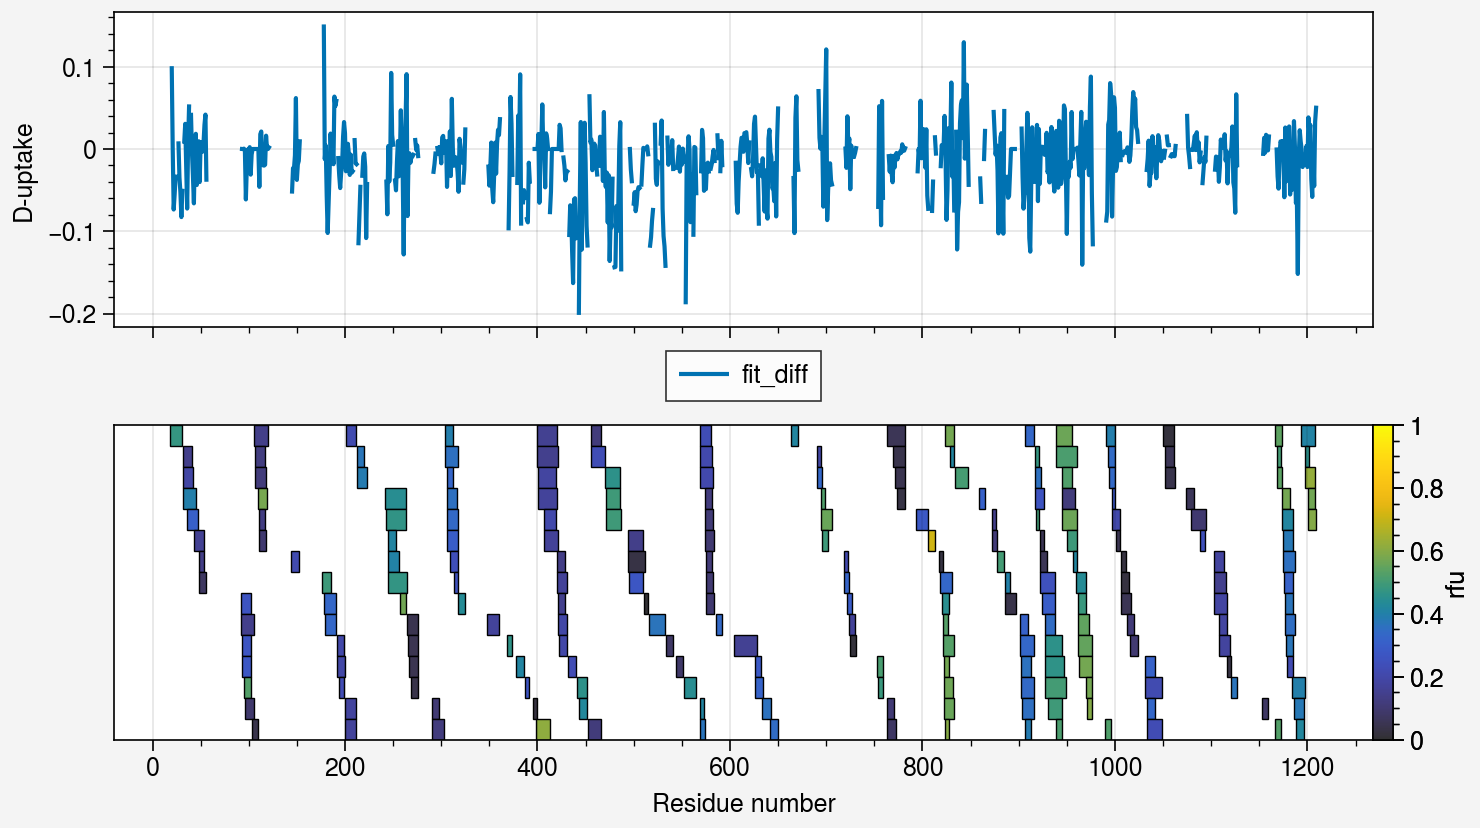

In [33]:
d_rfu = hdx_t.rfu_residues * 90.0 * 0.01

def prepare_kwargs(fit_result):
    """Prepare plot kwargs for fit result"""
    d = {
        "y": fit_result.d_uptake.mean(axis=0),
        "fadedata": np.percentile(fit_result.d_uptake, (5, 95), axis=0),
        "shadedata": np.percentile(fit_result.d_uptake, (25, 75), axis=0),
    }
    return d

fig, axes = pplt.subplots(nrows=2, refaspect=4, axwidth="160mm", sharey=False)
#axes[0].plot(hdx_t.r_number, d_inv, label="Matrix pinv", color="gray8")
#axes[0].plot(hdx_t.r_number, d_lsq, label="LSQ", color="gray5")

#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_1), label="fit_r1_1")
#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_02), label="fit_r1_02")
axes[0].line(hdx_t.r_number, fit_diff, label="fit_diff")

#axes[0].plot(hdx_t.r_number, d_rfu, label="RFU wt averaging")
axes[0].format(ylabel="D-uptake")
axes.format(xlabel="Residue number")
axes[0].legend(loc="b", ncols=5)
peptide_coverage(axes[1], hdx_t.data)
pplt.show()

In [31]:
# replace the b-factor by residue wise D-uptake
from Bio.PDB import PDBParser, PDBIO

# Define the path to your PDB file
pdb_file = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb'

# Create a PDB parser
parser = PDBParser()

# Parse the structure from file
structure = parser.get_structure('PDB', pdb_file)

# Define the chain you want to modify and the new B-factors
chain_id = 'B'  # Specify the chain ID
new_b_factors = d_uptake_dict # Dictionary of residue index to new B-factor values

# Update the B-factors for the specified chain
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    atom.bfactor = 0.0
                if residue.id[1] in new_b_factors:  # residue.id[1] gives the residue index
                    for atom in residue:
                        atom.bfactor = new_b_factors[residue.id[1]]

# Save the modified structure to a new PDB file
io = PDBIO()
io.set_structure(structure)
io.save('/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb')

In [6]:
import pandas as pd
import numpy as np

fpath = f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/HDX_pred_Omicron+V16noext_finetune.csv'
df = pd.read_csv(fpath)

batch_df = df[df['Batch'] == 'Hdock_Omicron+V16noext_1_revised']
print(batch_df.shape)

avg_uptake = {}
for chain in batch_df['Chain'].unique():
    chain_df = batch_df[batch_df['Chain'] == chain]
    for i, row in chain_df.iterrows():
        range_label = row['Range'].split('_')[1]
        if range_label not in avg_uptake.keys():
            avg_uptake[range_label] = []
        avg_uptake[range_label].append(float(row['Y_Pred']))
for key in avg_uptake.keys():
    avg_uptake[key] = np.mean(avg_uptake[key])
print(len(avg_uptake.keys()))

(347, 5)
117


In [46]:
# load protein as networkx graph and convert to torchdrug graph
import networkx as nx
import numpy as np
import torch
from torchdrug import data
from torch_cluster import knn_graph, radius_graph
from Bio.PDB import PDBParser, Selection

def rescale(data):
    data_max = np.max(data, axis=0)
    data_min = np.min(data, axis=0)
    
    # Avoid division by zero for constant columns by setting 0/0 to 0 directly
    range = np.where(data_max - data_min == 0, 1, data_max - data_min)
    
    rescaled_data = (data - data_min) / range
    rescaled_data = np.nan_to_num(rescaled_data, nan=0.0)
    
    return rescaled_data

def attach_node_attributes(G, embedding_file):
    embedding_data = torch.load(embedding_file)
    protein_embedding = rescale(embedding_data['embedding'].detach().numpy())
    for node in G.nodes():
        G.nodes[node]['x'] = torch.tensor(protein_embedding[node, :], dtype=torch.float32)
    return G

def ResGraph(pdb_file, embedding_file, protein_chain = ['A']): # create networkx and torchdrug graphs
    parser = PDBParser()
    structure = parser.get_structure('PDB_structure', pdb_file)
    # Filtering by protein_chain (assuming protein_chain can be a string or a list)
    if isinstance(protein_chain, str):
        chains = [chain for chain in structure.get_chains() if chain.id == protein_chain]
    else:
        chains = [chain for chain in structure.get_chains() if chain.id in protein_chain]
    residues = Selection.unfold_entities(chains, 'R')

    G = nx.MultiGraph()
    for i, residue in enumerate(residues):
        nodes_with_attributes = [
            (i, {"res_name": residue.get_resname(), "residue_coord":residue['CA'].coord, 
                 "residue_id": residue.id[1], 'chain_id': protein_chain.index(residue.get_parent().id)})
        ]
        G.add_nodes_from(nodes_with_attributes)
        #res(i, residue.get_resname(), protein_chain.index(residue.get_parent().id), residue['CA'].coord)
    
    G = attach_node_attributes(G, embedding_file)
    return G

def add_edges(G, max_distance=10, min_distance=5):
    node_coord = [G.nodes[i]['residue_coord'] for i in G.nodes]
    node_coord = torch.tensor(node_coord, dtype = torch.float32)
    batch = torch.tensor([0] * len(G.nodes))

    # add radius edges
    edge_index = radius_graph(node_coord, r=max_distance, batch=batch, loop=False)
    edge_list = edge_index.t().tolist()
    for u, v in edge_list:
        G.add_edge(u, v, edge_type='radius_edge')
    print('add radius edges:', G.number_of_edges())

    # add knn edges
    edge_index = knn_graph(node_coord, k=10, batch=batch, loop=False)
    edge_list = edge_index.t().tolist()
    for u, v in edge_list:
        G.add_edge(u, v, edge_type='knn_edge')
    print('add knn edges:', G.number_of_edges())

    # remove edges with distance smaller than min_distance
    edges_to_remove = []
    for u, v in G.edges():
        u_coord = torch.tensor(G.nodes[u]['residue_coord'], dtype = torch.float32)
        v_coord = torch.tensor(G.nodes[v]['residue_coord'], dtype = torch.float32)
        distance = torch.norm(u_coord - v_coord, dim=0)
        if distance < min_distance:
            if (u,v) not in edges_to_remove:
                edges_to_remove.append((u, v))
    G.remove_edges_from(edges_to_remove)
    print('after removing edges:', G.number_of_edges())

    # add sequential edges
    i2res_id = {(data['chain_id'], data['residue_id']): node for node, data in G.nodes(data=True)}
    for node in G.nodes:
        res_id = G.nodes[node]['residue_id']
        chain = G.nodes[node]['chain_id']
        if (chain,res_id+1) in i2res_id.keys():
            G.add_edge(node, node+1, edge_type='forward_1_edge')
        if (chain,res_id+2) in i2res_id.keys():
            G.add_edge(node, node+2, edge_type='forward_2_edge')
        if (chain,res_id-1) in i2res_id.keys():
            G.add_edge(node, node-1, edge_type='backward_1_edge')
        if (chain,res_id-2) in i2res_id.keys():
            G.add_edge(node, node-2, edge_type='backward_2_edge')
        G.add_edge(node, node, edge_type='self_edge')
    print('add sequential edges:', G.number_of_edges())
    return G

def networkx_to_tgG(G): # convert to torchdrug protein graph
    node_position = torch.as_tensor([G.nodes[node]['residue_coord'] for node in G.nodes()], dtype=torch.float32)
    num_atom = G.number_of_nodes()
    atom_type = ['CA'] * num_atom # CA - 1
    atom_type = torch.as_tensor([data.Protein.atom_name2id.get(atom, -1) for atom in atom_type])

    residue_type = []
    residue_feature = []
    residue_id = []
    id_map = {}
    for i, (node, attrs) in enumerate(G.nodes(data=True)):
        if node not in id_map.keys():
            id_map[node] = i
        residue_type.append(data.Protein.residue2id.get(attrs['res_name'], 0))
        residue_feature.append(attrs['x'])
        residue_id.append(attrs['residue_id'])
    residue_type = torch.tensor(residue_type, dtype=torch.long)
    residue_feature = torch.stack(residue_feature)
    atom2residue = torch.as_tensor([id_map[node] for node in G.nodes()], dtype=torch.long)

    edge_list = []
    bond_type = []
    edge_type_list = ['radius_edge', 'knn_edge', 'forward_1_edge', 'forward_2_edge', 'backward_1_edge', 'backward_2_edge', 'self_edge']
    for u, v, attrs in G.edges(data=True):
        edge_type = attrs['edge_type']
        u = id_map[u]
        v = id_map[v]
        if edge_type in edge_type_list:
            edge_list.append([u, v, edge_type_list.index(edge_type)])
            bond_type.append(edge_type_list.index(edge_type))

    edge_list = torch.tensor(edge_list, dtype=torch.long)
    bond_type = torch.tensor(bond_type, dtype=torch.long).unsqueeze(-1)

    protein = data.Protein(edge_list, atom_type, bond_type, view='residue', residue_number=residue_id,
                           node_position=node_position, atom2residue=atom2residue,residue_feature=residue_feature, 
                           residue_type=residue_type, num_relation = len(edge_type_list))
    '''
    with protein.graph():
        protein.y = torch.tensor(G.graph['y'], dtype=torch.float32)
        protein.range = torch.tensor(G.graph['range'], dtype=torch.float32)
        protein.chain = torch.tensor(G.graph['chain'], dtype=torch.int64)
        protein.seq_embedding = torch.tensor(G.graph['seq_embedding'], dtype=torch.float32)
    '''
    
    return protein

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/structure/AF-P03958-F1-model_v4.pdb'
embedding_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/embedding_files/AF-P03958-F1-model_v4.pt'
protein_chains = ['A']

G = ResGraph(pdb_fpath, embedding_fpath)
G = add_edges(G)
print(G)

node_list = range(5, 45)
print(node_list)
G = G.subgraph(node_list)
print(G)
protein = networkx_to_tgG(G)
print(protein)

add radius edges: 6762
add knn edges: 10282
after removing edges: 9845
add sequential edges: 11599
MultiGraph with 352 nodes and 11599 edges
range(5, 45)
MultiGraph with 40 nodes and 763 edges
atom_type: torch.Size([40])
{5: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 13, 19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39}
tensor(39)
Protein(num_atom=40, num_bond=763, num_residue=40)


In [1]:
from torchdrug import data, utils, tasks, core, layers
from torchdrug.layers import geometry
from GearNet import GearNet
from itertools import islice
import torch

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/structure/AF-O60664-F1-model_v4.pdb'
protein = data.Protein.from_pdb(pdb_fpath)
protein.view = 'residue'

graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()], 
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)])

_protein = data.Protein.pack([protein]*3)
protein_ = graph_construction_model(_protein)
print("Graph before: ", _protein)
print("Graph after: ", protein_)

model = GearNet(input_dim = 21, hidden_dims = [512,512,512],
                    num_relation=4, batch_norm=True, concat_hidden=True, readout='sum', short_cut=True)

train_loader = data.DataLoader([protein]*4, batch_size=2)
for i, batch in enumerate(islice(train_loader, len(train_loader))):
    print(torch.max(batch.edge_list[:, 2]))
    print(batch.num_relation)
    output = model(batch, batch.node_feature.float())
    print(output.shape)

ModuleNotFoundError: No module named 'GearNet'